### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
import random
import pickle

from skimage.io import imread
from skimage.io import imshow
import skimage.transform as trans
from skimage import exposure
from skimage.util import crop

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, log_loss, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.utils import resample, shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, normalize

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image 
from tensorflow.keras import datasets, layers, models
from keras.models import load_model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import InputLayer

### Section 1. Data Loading , Further Preprocessing & Data Analysis

#### Data Loading and Data Imbalance Check

Data is loaded from the Alzheimer's Dataset folder into train_images along with the number of images with a gray-scale filter

In [2]:
#Preparation of complete dataset without downsampled size

#For simplicity in our code for splitting -
#the test_data set from the original Kaggle datasets have been merged with the train_set

train_path = 'Alzheimer_s Dataset'

categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

train_images = []
original_labels = []

#Number of train_images of each category for our train_data
numberofimages = []

#similar to rmarkdown to get file directories
for category in categories:
    data_train_path = os.path.join(train_path, category)
    #store the number of images for each label in a list
    numberofimages.append(len(os.listdir(data_train_path)))

    for file in os.listdir(data_train_path):
        original_labels.append(category)
        train_image_paths = os.path.join(data_train_path, file) #image in this case refers to title of the image
        train_image = imread(train_image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all train_images)
        train_images.append(train_image)

We can see that there is a significant class imbalance which calls for the need of data augmentation for the training set obtained using the function train_test_split which is done is Section 2.

[3200, 2240, 896, 64]


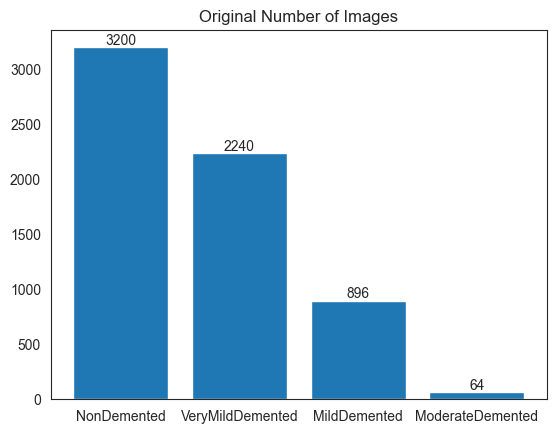

In [3]:
# Number of images for each data label / category within training data
print(numberofimages)

#Plot showing class imbalance
sns.set_style('white')
barplot = plt.bar(categories, numberofimages)
plt.title('Original Number of Images')
plt.bar_label(barplot , labels = numberofimages)
plt.show()

In [3]:
# Splitting of training dataset into a list of its respective categories
NonDemented = train_images[0:3200]
VeryMildDemented = train_images[3200:5440]
MildDemented = train_images[5440:6336]
ModerateDemented = train_images[6336:]

lst = [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]

We will check the dimensions of each image which gives us 208x176.

In [6]:
#Check dimensions of each raw data set
print(f"The dimensions of each image is : {train_images[0].shape}")

#Check if all data-set has the same dimensions
dim = train_images[0].shape
sum_of_incorrect = 0

for i in train_images:
    if i.shape != dim:
        sum_of_incorrect+=1

print(f"Number of images with incorrect dimensions are: {sum_of_incorrect}")

The dimensions of each image is : (208, 176)
Number of images with incorrect dimensions are: 0


#### Further Preprocessing and Data Analysis

##### Image Adjustments - Preprocessing

Since data has already been preprocessed as mentioned in Kaggle to the same headshape, further preprocessing will be done such as cropping the image to reduce the redundant features and decrease model training time.

We will first visualize what a random MRI image looks like.

New dimensions of test_image is : (208, 176)


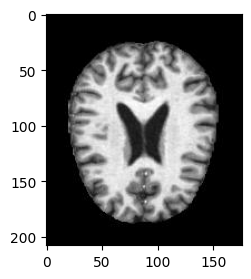

In [7]:
print(f'New dimensions of test_image is : {train_images[0].shape}')
plt.figure(figsize = (3,3))
plt.imshow(train_images[0], cmap = 'gray')
plt.show()

We can manually set the dimensions for cropping. We will do some testing it on one image before doing it for all images. 

Upon testing, a dimension from of 190x155 appears to be ideal with some allowance for the slightly different head sizes or for rotations during data augmentation.

New dimensions of test_image is : (190, 155)


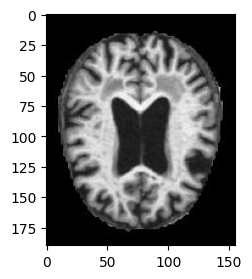

In [8]:
imageTest = train_images[100][10:200, 10:165]
print(f'New dimensions of test_image is : {imageTest.shape}')
plt.figure(figsize = (3,3))
plt.imshow(imageTest, cmap = 'gray')
plt.show()

In [4]:
#Cropping of images
for i in range(len(train_images)):
    new_cropped_image = train_images[i][10:200, 10:165]
    train_images[i] = new_cropped_image

#For lst that is split into categories(Needed to make data viz simpler)
for category in lst:
    for i in range(len(category)):
        new_cropped_image = category[i][10:200, 10:165]
        category[i] = new_cropped_image


5 samples of images from each category is shown. 

Some images are darker than others such as the third picture under VeryMildDemented.

To combat this, we can perform contrast limited adaptive histogram equalization(CLAHE) on images with a low contrast. We will be using a large kernel size so that this filter distributes pixels over a larger range.

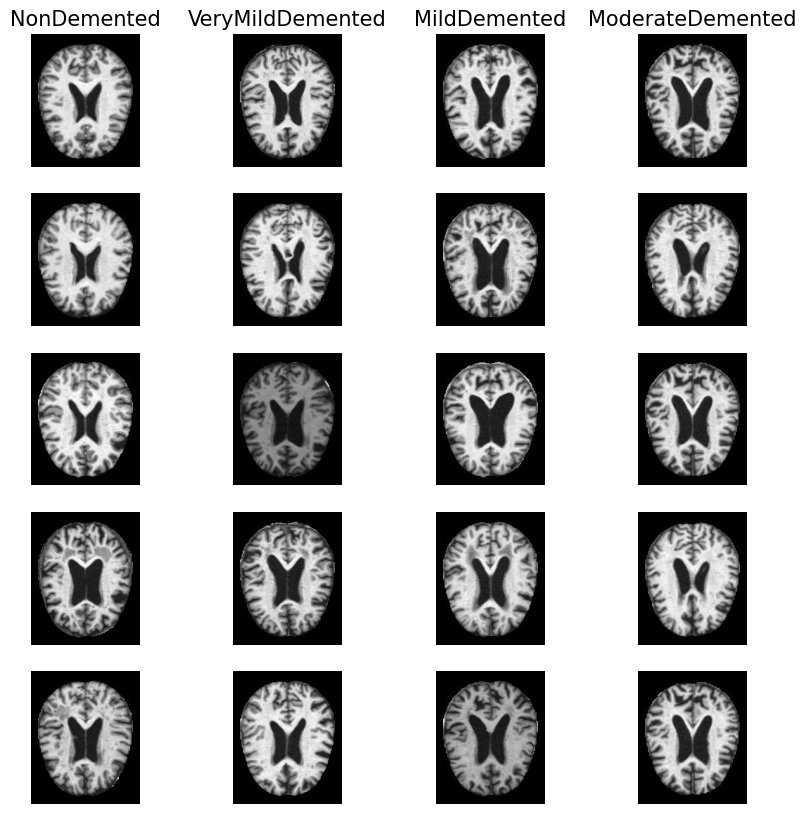

In [10]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like using the original dataset
fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('NonDemented', fontsize = 15)
axes[0,1].set_title('VeryMildDemented', fontsize = 15)
axes[0,2].set_title('MildDemented', fontsize = 15)
axes[0,3].set_title('ModerateDemented', fontsize = 15)
plt.show()

In [11]:
storedImage = lst[1][2] #For Comparison

In [5]:
#function to run for hist eq
def hist_eq(image):
    if (exposure.is_low_contrast(image, fraction_threshold = 0.80)): #Only if contrast is low enough, then we perform equalization
        image = exposure.equalize_adapthist(image, clip_limit=0.009, kernel_size = (8,8))
    return image

In [6]:
for i in range(len(train_images)):
    train_images[i] = hist_eq(train_images[i])

#For lst that is split into categories(Needed to make data viz simpler)
for category in lst:
    for i in range(len(category)):
        category[i] = hist_eq(category[i])        


This is how a low contrast image looks after histogram equalization.

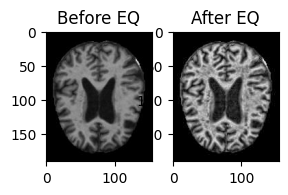

In [14]:
fig, axes = plt.subplots(1,2, figsize = (3,3))
axes[0].imshow(storedImage, cmap = 'gray')
axes[1].imshow(lst[1][2], cmap = 'gray')

#Titles
axes[0].set_title('Before EQ')
axes[1].set_title('After EQ')
plt.show()

However, CLAHE results in some images being on a scale of [0,1] whereas the original images are [0,255].

We will perform normalization to ensure all images are in a [0,1] scale. This scale was chosen to prevent exploding gradients.

In [7]:
scale_1 = 0
scale_2 = 0
for i in range(len(train_images)):
    if np.max(train_images[i]) == 1:
        scale_1 += 1
    if np.max(train_images[i]) == 255:
        scale_2 +=1
print(f'The number of images on a [0,1] scale is approximately: {scale_1}')
print(f'The number of images on a [0,255] scale is approximately: {scale_2}')

The number of images on a [0,1] scale is approximately: 443
The number of images on a [0,255] scale is approximately: 4308


In [8]:
def normalisation(image):
    p_min = np.min(image)
    p_max = np.max(image)
    image = (image - p_min) / (p_max - p_min)
    return image

In [9]:
for i in range(len(train_images)):
    train_images[i] = normalisation(train_images[i])


for category in lst:
    for i in range(len(category)):
        category[i] = normalisation(category[i])  

##### Pixel Analysis

Let's now analyse the the frequency of each pixel gray-scale value for 40 images using a histogram.

This is done to investigate whether there is a relationship between frequency of each pixel values and the classes.

In [17]:
frequency = []
for categories in lst:
    total = 0 #Starting np array
    flat = []
    for image_idx in range(40):
        total += categories[image_idx] / 40
        flat.extend(total.flatten())
    frequency.append(flat)



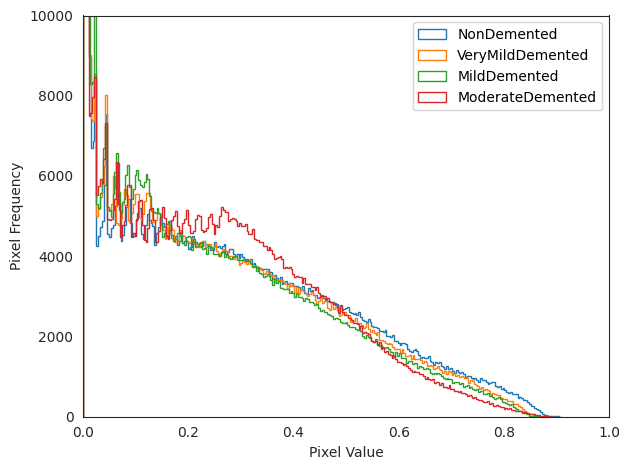

In [18]:
for i in range(len(frequency)):
    plt.hist(frequency[i], bins = 256, histtype = 'step')
    plt.xlim(0,1)
    plt.ylim(0,10000)

plt.style.use('default')
plt.xlabel('Pixel Value')
plt.ylabel('Pixel Frequency')
plt.legend(('NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'))
plt.tight_layout()

plt.show()

There appears to be no correlation with pixel frequency and most class labels. But there seems to be a relationship in pixel values between 0.2 to 0.6 for ModerateDemented.

It might be a good idea to use a binary mask filter, we can apply a binary filter from pixel values ranging from 0.2 to 0.6. Furthermore, since this does not account for spatial relationships between pixels, this could help us identify whether the amount of grey matter is useful for detecting Alzheimers.


### Section 2: Data Preparation 

##### Upsampling of Data

Before doing any data augmentation, we will first split the data into train and test sets to prevent data leakage.

In [10]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(train_images,  original_labels, random_state=9)

These are the functions we need for augmentation. It is done by rotating our images slightly to maintain a somewhat straight orientation of photos.

In [11]:
def moderate_augmentation(image, label, training_images, training_labels):
    training_images.append(trans.rotate(image, 348))
    training_images.append(trans.rotate(image, 5))
    training_images.append(trans.rotate(image,355))
    training_images.append(trans.rotate(image, 8))
    training_images.append(trans.rotate(image, 362))
    training_images.append(trans.rotate(image, 3))
    training_images.append(trans.rotate(image,357))
    training_images.append(trans.rotate(image,350))
    training_images.append(trans.rotate(image,352))
    training_images.append(trans.rotate(image,10))
    training_images.append(trans.rotate(image,348))
    training_images.append(trans.rotate(image,345))
    training_images.append(trans.rotate(image,15))
    training_images.append(trans.rotate(image,12))
    training_images.append(trans.rotate(image[::-1], 180))

    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)
    training_labels.append(label)

    

def mild_augmentation(image, label, training_images, training_labels):
    training_images.append(trans.rotate(image, 5))
    training_images.append(trans.rotate(image,355))

    training_labels.append(label)
    training_labels.append(label)

Here, we will check the how bad the class imbalance is in our training set and do data augmentation accordingly.

In [12]:
training_lst = []
NonDemented_train = []
VeryMildDemented_train = []
MildDemented_train= []
ModerateDemented_train = []
train_numberofImages = []


for i in range(len(X_train_base)):
    if y_train_base[i] == 'NonDemented':
        NonDemented_train.append(X_train_base[i])

    if y_train_base[i] == 'VeryMildDemented':
        VeryMildDemented_train.append(X_train_base[i])

    if y_train_base[i] == 'MildDemented':
        MildDemented_train.append(X_train_base[i])

    if y_train_base[i] == 'ModerateDemented':
        ModerateDemented_train.append(X_train_base[i])

training_lst.append(NonDemented_train)
train_numberofImages.append(len(NonDemented_train))

training_lst.append(VeryMildDemented_train)
train_numberofImages.append(len(VeryMildDemented_train))

training_lst.append(MildDemented_train)
train_numberofImages.append(len(MildDemented_train))

training_lst.append(ModerateDemented_train)
train_numberofImages.append(len(ModerateDemented_train))

MildDemented and ModerateDemented are very unbalanced compared to NonDemented and VeryMildDemented. We will do upsampling here to retain as much information as possible while still keeping the relative distribution.

In [13]:
categories = ('NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented')

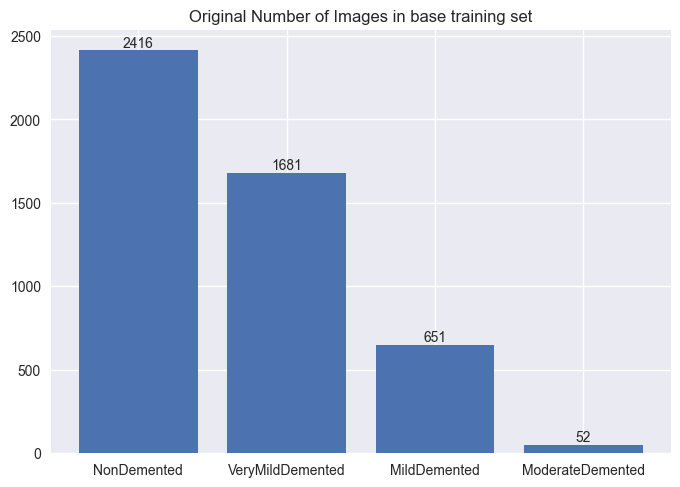

In [23]:
plt.style.use('seaborn')
barplot = plt.bar(categories, train_numberofImages)
plt.title('Original Number of Images in base training set')
plt.bar_label(barplot , labels = train_numberofImages)
plt.show()

In [14]:
#Upsampling
X_train_augmented = []
y_train_augmented = []
for i in range(len(X_train_base)):
    if y_train_base[i] == 'ModerateDemented':
        moderate_augmentation(X_train_base[i], y_train_base[i], X_train_augmented, y_train_augmented)
    if y_train_base[i] == 'MildDemented':
        mild_augmentation(X_train_base[i], y_train_base[i], X_train_augmented, y_train_augmented)
    else:
        X_train_augmented.append(X_train_base[i])
        y_train_augmented.append(y_train_base[i])

Since augmented images were appended, we will now do shuffling of the images to prevent models from learning patterns related to the order of the images.

We will also now see the new number of images in each class after upsampling and shuffling.



In [15]:
X_train_augmented,y_train_augmented = shuffle(X_train_augmented,y_train_augmented, random_state= 9)

In [16]:
## Just to get the number of images and to split it into its respective category
training_lst_aug = []
NonDemented_train_aug = []
VeryMildDemented_train_aug = []
MildDemented_train_aug = []
ModerateDemented_train_aug = []
train_numberofImages_aug = []


for i in range(len(X_train_augmented)):
    if y_train_augmented[i] == 'NonDemented':
        NonDemented_train_aug.append(X_train_augmented[i])

    if y_train_augmented[i] == 'VeryMildDemented':
        VeryMildDemented_train_aug.append(X_train_augmented[i])

    if y_train_augmented[i] == 'MildDemented':
        MildDemented_train_aug.append(X_train_augmented[i])

    if y_train_augmented[i] == 'ModerateDemented':
        ModerateDemented_train_aug.append(X_train_augmented[i])

training_lst_aug.append(NonDemented_train_aug)
train_numberofImages_aug.append(len(NonDemented_train_aug))

training_lst_aug.append(VeryMildDemented_train_aug)
train_numberofImages_aug.append(len(VeryMildDemented_train_aug))

training_lst_aug.append(MildDemented_train_aug)
train_numberofImages_aug.append(len(MildDemented_train_aug))

training_lst_aug.append(ModerateDemented_train_aug)
train_numberofImages_aug.append(len(ModerateDemented_train_aug))


After augmentation, the number of ModerateDemented has increased to 832 samples and MildDemented to 1302 samples.

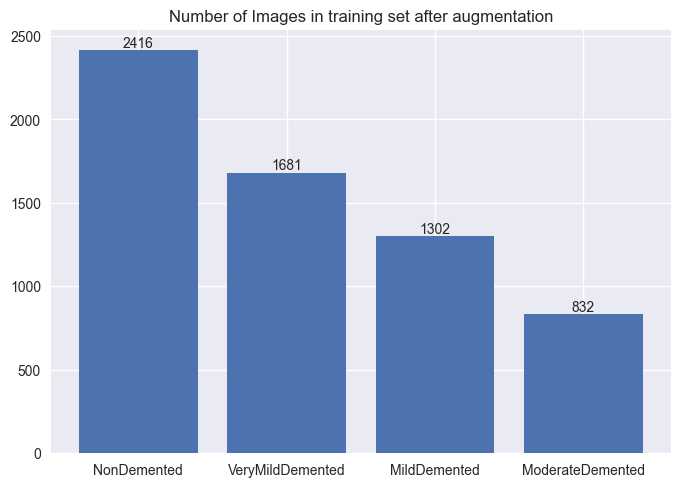

In [27]:
plt.style.use('seaborn')
barplot = plt.bar(categories, train_numberofImages_aug)
plt.title('Number of Images in training set after augmentation')
plt.bar_label(barplot , labels = train_numberofImages_aug)
plt.show()

Below is how an image looks like after a rotation.

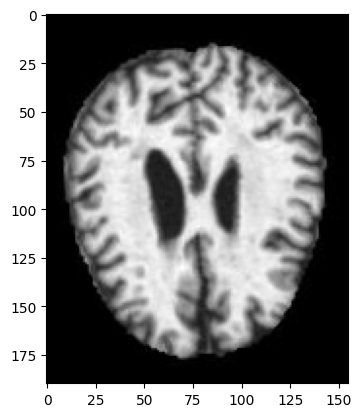

In [24]:
plt.style.use('default')
plt.imshow(ModerateDemented_train_aug[10], cmap = 'gray')
plt.show()

In [40]:
test_lst_aug = []
NonDemented_test = []
VeryMildDemented_test = []
MildDemented_test = []
ModerateDemented_test = []
test_numberofImages = []


for i in range(len(y_test_base)):
    if y_test_base[i] == 'NonDemented':
        NonDemented_test.append(X_train_augmented[i])

    if y_test_base[i] == 'VeryMildDemented':
        VeryMildDemented_test.append(X_train_augmented[i])

    if y_test_base[i] == 'MildDemented':
        MildDemented_test.append(X_train_augmented[i])

    if y_test_base[i] == 'ModerateDemented':
        ModerateDemented_test.append(X_train_augmented[i])

test_lst_aug.append(NonDemented_test)
test_numberofImages.append(len(NonDemented_test))

test_lst_aug.append(VeryMildDemented_train_aug)
test_numberofImages.append(len(VeryMildDemented_train_aug))

test_lst_aug.append(MildDemented_test)
test_numberofImages.append(len(MildDemented_test))

test_lst_aug.append(ModerateDemented_test)
test_numberofImages.append(len(ModerateDemented_test))

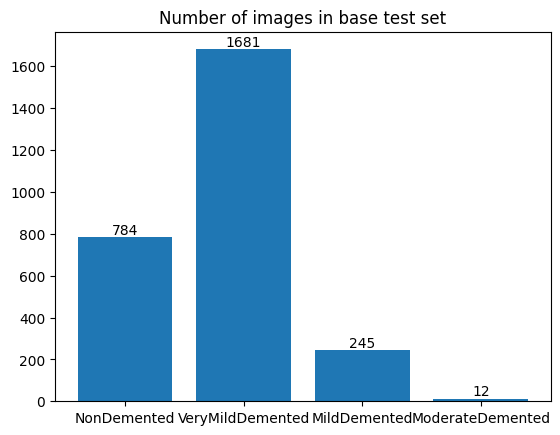

In [41]:
barplot = plt.bar(categories, test_numberofImages)
plt.title('Number of images in base test set')
plt.bar_label(barplot , labels = test_numberofImages)
plt.show()

#### Preparing training data for linear models

We will prepare 2 additional training and test data set with a binary filter applied and with linear discriminant analysis for feature reduction.

This gives us a total of three training sets.

1. Base Training Set

2. Binary Filter Training Set

3. LDA Training Set

##### Base Training Set

In [17]:
baseX_train = []
baseX_test = []
baseY_train = y_train_augmented
baseY_test = y_test_base
for i in X_train_augmented:
    baseX_train.append(i.flatten())

for i in X_test_base:
    baseX_test.append(i.flatten())

##### Binary Training Set

We can apply a binary filter over a range [0.2,0.6], to see if its meaningful features selected as there is data variation in that region, especially for ModerateDemented although there appears to be little correlation.

In [18]:
binaryX_train_nonFlat = []
binaryX_train = [] #Our actual training set

#We will apply filter but leave this untouched
binaryX_test = []

for image in X_train_augmented:
    img = np.where((image >= 0.2) & (image<= 0.6), 1,0)
    binaryX_train_nonFlat.append(img)
    binaryX_train.append(img.flatten())

#DO NOT TOUCH until model prediction
for image in X_test_base:
    img = np.where((image >= 0.2) & (image<= 0.6), 1,0)
    binaryX_test.append(img.flatten())

In [28]:
binaryX_train_nonFlat[1].shape

(190, 155)

This is how an image looks after applying a binary filter.

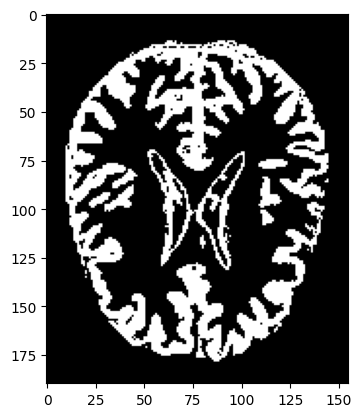

In [29]:
#Image after binary mask application
plt.style.use('default')
plt.imshow(binaryX_train_nonFlat[1], cmap = 'gray')
plt.show()

##### LDA Training Set

One potential improvement is by performing LDA on our dataset to speed up linear model training time and we will investigate whether LDA is useful for images. Additionally, LDA helps increase linear separability in our data, and mitigates the curse of dimensionality since we are dealing with complex image data, therefore reducing the dimensionality of the data.

In [19]:
lda = LinearDiscriminantAnalysis()
lda_baseX_train = lda.fit_transform(baseX_train, y_train_augmented)

##### Preparation of Detection Labels

We will create labels where NonDemented classes are labelled as 0, and other classes are labelled as 1 and can be categorized as IsDemented.

In [20]:
detectionLabels = np.where(np.array(y_train_augmented) == 'NonDemented', 0, 1)

Here, we will be checking that our training sets have equal dimensions before being used for the model.

In [30]:
#Checking if all X_train sets have same dimensions(excluding LDA)
for i in baseX_train:
    if len(i) != 29450:
        print('y')

for i in binaryX_train:
    if len(i) != 29450:
        print('y')

##### Choosing of Evaluation Metrics

We will now identify the class imbalance in our original base training set without augmentation as this will serve as a good estimator for our category distribution in our test set, which will help us decide our evaluation metrics.

Since there is roughly the same distribution, we shall use accuracy and recall. Accuracy will measure how many true negatives and true positives are correctly identified. Recall is used to measure the models with the lowest false negatives rates. This is crucial because it is essential to ensure patients with Alzheimers are correctly identified due to the severity of the disease, even at the expense of having higher false positives.

<BarContainer object of 2 artists>

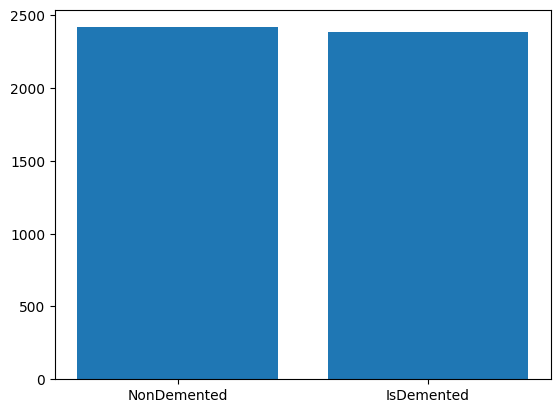

In [36]:
NonDemented_num = train_numberofImages[0]
IsDemented_num = sum(train_numberofImages[1:])
total_nums = [NonDemented_num, IsDemented_num]
plt.bar(['NonDemented','IsDemented'], total_nums)

#### Preparation for CNN Model and mcSVM models

The training set for the CNN training data that has been reshaped to fit the tensorflow keras model. No further changes will be made this training set.

The training set for our multi-class SVM(mcSVM) model for classification of the severity of Alzheimers are as follows.

1. Base mcSVM Training Set

2. LDA mcSVM Training Set


All of them use the following labels. [NonDemented, VeryMildDemented, MildDemented, ModerateDemented]


##### Preparation of CNN Training Set

In [21]:
#CNN data
baseImages3D = X_train_augmented.copy() #Creates a new coppy
baseImages3D = np.array(baseImages3D).reshape(-1, 190,155,1)
cnn_X_train = baseImages3D

The code below does one-hot encoding for the CNN data.

[0,0,1,0] refers to NonDemented

[0,0,0,1] refers to VeryMildDemented

[1,0,0,0] refers to Mild Demented

[0,1,0,0] refers to ModerateDemented


In [32]:
labelsGet = pd.get_dummies(y_train_augmented)
cnn_labels = labelsGet.values

In [33]:
cnn_labels

array([[False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False],
       ...,
       [False,  True, False, False],
       [False, False, False,  True],
       [False, False, False,  True]])

##### Preparation of mcSVM Training Set

In [22]:
mcSVM_train_images = baseX_train
mcSVM_train_labels_get = baseY_train

We will use a dictionary to label our training set.

In [23]:
label_map = {'NonDemented': 0, 'VeryMildDemented': 1, 'MildDemented': 2, 'ModerateDemented':3}

In [24]:
mcSVM_train_labels = [label_map[label] for label in mcSVM_train_labels_get]

##### Choosing of Evaluation Metrics

From the graph plotted in about the original distribution of our images. There is a massive class imbalance between categories. It would be better to use an AUC-ROC score along with the macro F1 score to compare performances between models.

#### Preparation of Test Sets and Labels for Model Evaluation

##### Preparation for Linear Models

In [25]:
detectionLabels_test = np.where(np.array(baseY_train) == 'NonDemented', 0, 1)
#One hot encoded labels for base_Y_test
base_Y_test_ohc = np.where(np.array(y_test_base) == 'NonDemented', 0, 1)
lda_baseX_test = lda.transform(baseX_test)

##### Preparation for mcSVM models

In [26]:
mcSVM_test_images = baseX_test
mcSVM_test_labels_get = baseY_test
mcSVM_test_labels = [label_map[label] for label in mcSVM_test_labels_get]

##### Preparation for CNN model

In [34]:
cnn_test_labels = pd.get_dummies(y_test_base)
cnn_image_test = np.array(X_test_base).reshape(-1, 190,155,1)

### Section 3. Model Training & Results

#### Linear Models for Dectection (Binary Classification)

Models will follow this format: Base set, Binary set, LDA set using a KFold of 5. For models using base_images(except LDA), we will tune the hyper-parameters using GridSearchCV for the base models

In [46]:
#Default is 5
kf = KFold()

##### Logistic Regression Models

In [47]:
logregBase_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 10)), 'class_weight': ['balanced', None]}

#run logistic regression models
logregBase = GridSearchCV(LogisticRegression(random_state = 9,n_jobs = -1) , logregBase_parameters, cv = kf) 
logregBase.fit(baseX_train,detectionLabels)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 

100 fits failed out of a total of 200.

The score on these train-test partitions for these parameters will be set to nan.

If these failures are not expected, you can try to debug them by setting error_score='raise'.



Below are more details about the failures:

--------------------------------------------------------------------------------

100 fits failed with the following error:

Traceback (most recent call last):

  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper

    return fit_method(estimator, *args, **kwargs)

  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(n_jobs=-1, random_state=9),
             param_grid={'C': [1e-05, 0.2222311111111111, 0.4444522222222222,
                               0.6666733333333332, 0.8888944444444443,
                               1.1111155555555556, 1.3333366666666666,
                               1.5555577777777776, 1.7777788888888888, 2.0],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']})

In [48]:
logregBinary_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 10)), 'class_weight': ['balanced', None]}
logregBinary = GridSearchCV(LogisticRegression(random_state = 9,n_jobs = -1) , logregBinary_parameters, cv = kf) 
logregBinary.fit(binaryX_train, detectionLabels)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 

100 fits failed out of a total of 200.

The score on these train-test partitions for these parameters will be set to nan.

If these failures are not expected, you can try to debug them by setting error_score='raise'.



Below are more details about the failures:

--------------------------------------------------------------------------------

100 fits failed with the following error:

Traceback (most recent call last):

  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score

    estimator.fit(X_train, y_train, **fit_params)

  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1474, in wrapper

    return fit_method(estimator, *args, **kwargs)

  File "c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(n_jobs=-1, random_state=9),
             param_grid={'C': [1e-05, 0.2222311111111111, 0.4444522222222222,
                               0.6666733333333332, 0.8888944444444443,
                               1.1111155555555556, 1.3333366666666666,
                               1.5555577777777776, 1.7777788888888888, 2.0],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']})

In [49]:
logregLDA = LogisticRegressionCV(cv = kf, random_state= 9,n_jobs = -1)
logregLDA.fit(lda_baseX_train, detectionLabels)

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     n_jobs=-1, random_state=9)

In [50]:
##Save the models
pickle.dump(logregBase , open('logregBase.pkl' , 'wb'))
pickle.dump(logregBinary , open('logregBinary.pkl' , 'wb'))
pickle.dump(logregLDA, open('logregLDA.pkl' , 'wb'))

In [27]:
#reopening saved models to prevent retraining
with open ('logregBase.pkl', 'rb') as file:
    logregBase = pickle.load(file)

with open ('logregBinary.pkl', 'rb') as file:
    logregBinary = pickle.load(file)

with open ('logregLDA.pkl', 'rb') as file:
    logregLDA = pickle.load(file)

##### Logistic Regression Results

In [28]:
logregBase_ypred_test = logregBase.predict(baseX_test)
logregBase_ypred_train = logregBase.predict(baseX_train)

Results

In [53]:
#Evaluating the model via evaluative metrics

print("Base Logistic Regression Metrics for Training Data")
logregBase_cm_train = confusion_matrix(detectionLabels, logregBase_ypred_train)
print('Confusion Matrix')
print(logregBase_cm_train)

print('Classification Report')
print(classification_report(detectionLabels, logregBase_ypred_train))

print('\n')

print("Base Logistic Regression Metrics for Test Data")
print('Accuracy')
print(logregBase.score(baseX_test, base_Y_test_ohc))
print('Confusion Matrix')
logregBase_cm_test = confusion_matrix(base_Y_test_ohc, logregBase_ypred_test)
print(logregBase_cm_test)

print('Classification Report')
print(classification_report(base_Y_test_ohc, logregBase_ypred_test))

Base Logistic Regression Metrics for Training Data

Confusion Matrix

[[2416    0]

 [   0 3815]]

Classification Report

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      3815



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231







Base Logistic Regression Metrics for Test Data

Accuracy

0.92375

Confusion Matrix

[[760  24]

 [ 98 718]]

Classification Report

              precision    recall  f1-score   support



           0       0.89      0.97      0.93       784

           1       0.97      0.88      0.92       816



    accuracy                           0.92      1600

   macro avg       0.93      0.92      0.92      1600

weighted avg       0.93      0.92      0.92      1600




In [32]:
#Base logistic regression training variance
lrBase_train_var = np.mean(detectionLabels != logregBase_ypred_train)
print("Variance (base logistic regression training data):", lrBase_train_var)

#Base logistic regression test variance
lrBase_test_var = np.mean(base_Y_test_ohc != logregBase_ypred_test)
print("Variance (base logistic regression training data):", lrBase_test_var)

Variance (base logistic regression training data): 0.0065800032097576636
Variance (base logistic regression training data): 0.0575


In [42]:
lrBase_test_auc = roc_auc_score(base_Y_test_ohc, logregBase_ypred_test)
print("Base Logistic Regression AUC (Test Data):", lrBase_test_auc)

Base Logistic Regression AUC (Test Data): 0.943577430972389


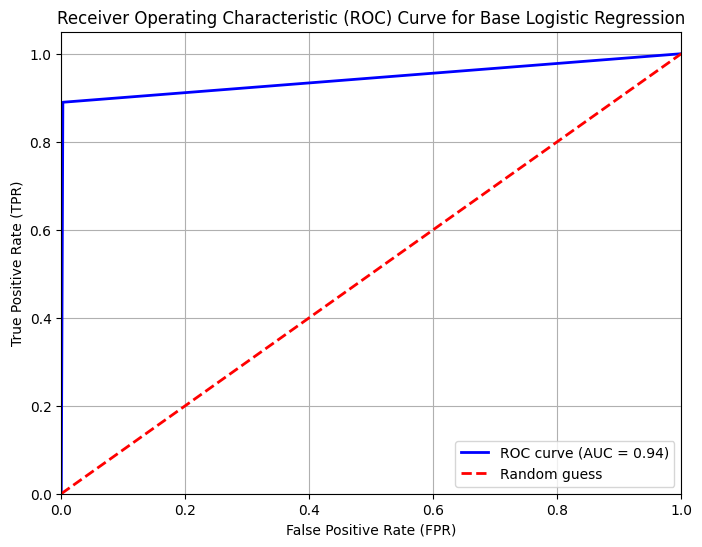

In [43]:
#ROC-AUC curve
logregBase_fpr, logregBase_tpr, logregBase_thresholds = roc_curve(base_Y_test_ohc, logregBase_ypred_test)

plt.figure(figsize=(8, 6))
plt.plot(logregBase_fpr, logregBase_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % lrBase_test_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Base Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [33]:
logregBinary_ypred_test = logregBinary.predict(binaryX_test)
logregBinary_ypred_train = logregBinary.predict(binaryX_train)

In [55]:
print("Binary Logistic Regression Metrics for Training Data")

print('Confusion Matrix')
logregBinary_cm_train = confusion_matrix(detectionLabels, logregBinary_ypred_train)
print(logregBinary_cm_train)

print('Classfication Report')
print(classification_report(detectionLabels, logregBinary_ypred_train))
print('\n')
print("Binary Logistic Regression Metrics for Test Data")
print('Accuracy')
print(logregBinary.score(binaryX_test, base_Y_test_ohc))
print('Confusion Matrix')
logregBinary_cm_test = confusion_matrix(base_Y_test_ohc, logregBinary_ypred_test)
print(logregBinary_cm_test)

print('Classfication Report')
print(classification_report(base_Y_test_ohc, logregBinary_ypred_test))

Binary Logistic Regression Metrics for Training Data

Confusion Matrix

[[2416    0]

 [   0 3815]]

Classfication Report

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      3815



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231







Binary Logistic Regression Metrics for Test Data

Accuracy
0.8875

Confusion Matrix

[[742  42]

 [138 678]]

Classfication Report

              precision    recall  f1-score   support



           0       0.84      0.95      0.89       784

           1       0.94      0.83      0.88       816



    accuracy                           0.89      1600

   macro avg       0.89      0.89      0.89      1600

weighted avg       0.89      0.89      0.89      1600




In [36]:
#Binary logistic regression training data

lrBinary_train_var = np.mean(detectionLabels != logregBinary_ypred_train)
print("Variance (base logistic regression training data):", lrBinary_train_var)

#Binary logistic regression test data

lrBinary_test_var = np.mean(base_Y_test_ohc != logregBinary_ypred_test)
print("Variance (base logistic regression test data):", lrBinary_test_var)

Variance (base logistic regression training data): 0.010431712405713368
Variance (base logistic regression test data): 0.07625


LDA Logistic Regression

In [37]:
logregLDA_ypred_test = logregLDA.predict(lda_baseX_test)
logregLDA_ypred_train = logregLDA.predict(lda_baseX_train)

In [57]:
print("LDA Logistic Regression Metrics for Training Data")
lda_cm_train = confusion_matrix(detectionLabels, logregLDA_ypred_train)
print('Confusion Matrix')
print(lda_cm_train)

print('Classfication Report')
print(classification_report(detectionLabels, logregLDA_ypred_train))

print('\n')
print("LDA Logistic Regression Metrics for Test Data")
print('Accuracy')
print(logregLDA.score(lda_baseX_test, base_Y_test_ohc))
print('Confusion Matrix')
lda_cm_test = confusion_matrix(base_Y_test_ohc, logregLDA_ypred_test)
print(lda_cm_test)
print('Classfication Report')
print(classification_report(base_Y_test_ohc, logregLDA_ypred_test))

LDA Logistic Regression Metrics for Training Data

Confusion Matrix

[[2415    1]

 [   3 3812]]

Classfication Report

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      3815



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231







LDA Logistic Regression Metrics for Test Data

Accuracy

0.87875

Confusion Matrix

[[750  34]

 [160 656]]

Classfication Report

              precision    recall  f1-score   support



           0       0.82      0.96      0.89       784

           1       0.95      0.80      0.87       816



    accuracy                           0.88      1600

   macro avg       0.89      0.88      0.88      1600

weighted avg       0.89      0.88      0.88      1600




In [39]:
#LDA Logistic Regression training data
lrLDA_train_var = np.mean(detectionLabels != logregLDA_ypred_train)
print("Variance (LDA logistic regression training data):", lrLDA_train_var)

#LDA Logistic Regression test data
lrLDA_test_var = np.mean(base_Y_test_ohc != logregLDA_ypred_test)
print("Variance (LDA logistic regression training data):", lrLDA_test_var)

Variance (LDA logistic regression training data): 0.0008024394158241052
Variance (LDA logistic regression training data): 0.1325


##### SVM Models using Linear Kernel

In [58]:
base_svm_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 10)), 'class_weight': ['balanced', None]}
base_svm = GridSearchCV(LinearSVC(random_state= 9), base_svm_parameters, cv = kf)
base_svm.fit(baseX_train, detectionLabels)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value o

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LinearSVC(random_state=9),
             param_grid={'C': [1e-05, 0.2222311111111111, 0.4444522222222222,
                               0.6666733333333332, 0.8888944444444443,
                               1.1111155555555556, 1.3333366666666666,
                               1.5555577777777776, 1.7777788888888888, 2.0],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']})

In [59]:
binary_svm_parameters = {'penalty': ['l1','l2'], 'C': list(np.linspace(0.00001,2, num = 10)), 'class_weight': ['balanced', None]}
binary_svm = GridSearchCV(LinearSVC(random_state= 9), binary_svm_parameters, cv = kf)
binary_svm.fit(binaryX_train, detectionLabels)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value o

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LinearSVC(random_state=9),
             param_grid={'C': [1e-05, 0.2222311111111111, 0.4444522222222222,
                               0.6666733333333332, 0.8888944444444443,
                               1.1111155555555556, 1.3333366666666666,
                               1.5555577777777776, 1.7777788888888888, 2.0],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2']})

In [60]:
lda_svm = LinearSVC()
lda_svm.fit(baseX_train, detectionLabels)

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.

  warnings.warn(

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.

  warnings.warn(


LinearSVC()

In [61]:
pickle.dump(base_svm , open('base_svm.pkl' , 'wb'))
pickle.dump(binary_svm , open('binary_svm.pkl' , 'wb'))
pickle.dump(lda_svm, open('lda_svm.pkl' , 'wb'))

In [44]:
with open ('base_svm.pkl', 'rb') as file:
    base_svm = pickle.load(file)

with open ('binary_svm.pkl', 'rb') as file:
    binary_svm = pickle.load(file)

with open ('lda_svm.pkl', 'rb') as file:
    lda_svm = pickle.load(file)

##### SVM Models Results

In [45]:
baseSVM_ypred_train = base_svm.predict(baseX_train)
baseSVM_ypred_test = base_svm.predict(baseX_test)

In [64]:
print("Base SVM Metrics for Training Data")

svmBase_cm_train = confusion_matrix(detectionLabels, baseSVM_ypred_train)
print(svmBase_cm_train)
print(classification_report(detectionLabels, baseSVM_ypred_train))

print('\n')

print("Base SVM Metrics for Test Data")
print('Accuracy')
print(base_svm.score(baseX_test, base_Y_test_ohc))
svmBase_cm_test = confusion_matrix(base_Y_test_ohc, baseSVM_ypred_test)
print(svmBase_cm_test)

print(classification_report(base_Y_test_ohc, baseSVM_ypred_test))

Base SVM Metrics for Training Data

[[2416    0]

 [   0 3815]]

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      3815



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231







Base SVM Metrics for Test Data

Accuracy

0.9375

[[769  15]

 [ 85 731]]

              precision    recall  f1-score   support



           0       0.90      0.98      0.94       784

           1       0.98      0.90      0.94       816



    accuracy                           0.94      1600

   macro avg       0.94      0.94      0.94      1600

weighted avg       0.94      0.94      0.94      1600




In [47]:
#Base SVM training data
baseSVM_train_var = np.mean(detectionLabels != baseSVM_ypred_train)
print("Variance (base SVM training data):", baseSVM_train_var)

#Base SVM test data
baseSVM_test_var = np.mean(base_Y_test_ohc != baseSVM_ypred_test)
print("Variance (base SVM test data):", baseSVM_test_var)

Variance (base SVM training data): 0.003691221312790884
Variance (base SVM test data): 0.0525


Binary SVM Model Evaluation

In [48]:
binarySVM_ypred_train = binary_svm.predict(binaryX_train)
binarySVM_ypred_test = binary_svm.predict(binaryX_test)

In [66]:
print("Binary SVM Metrics for Training Data")

svmBinary_cm_train = confusion_matrix(detectionLabels, binarySVM_ypred_train)
print(svmBinary_cm_train)
print(classification_report(detectionLabels, binarySVM_ypred_train))

print('\n')

print("Binary SVM Metrics for Test Data")
print('Accuracy')
print(binary_svm.score(binaryX_test, base_Y_test_ohc))
svmBinary_cm_test = confusion_matrix(base_Y_test_ohc, binarySVM_ypred_test)
print(svmBinary_cm_test)

print(classification_report(base_Y_test_ohc, binarySVM_ypred_test))

Binary SVM Metrics for Training Data

[[2416    0]

 [   0 3815]]

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      3815



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231







Binary SVM Metrics for Test Data

Accuracy

0.89375

[[743  41]

 [129 687]]

              precision    recall  f1-score   support



           0       0.85      0.95      0.90       784

           1       0.94      0.84      0.89       816



    accuracy                           0.89      1600

   macro avg       0.90      0.89      0.89      1600

weighted avg       0.90      0.89      0.89      1600




In [50]:
#Binary SVM Training Data
binarySVM_train_var = np.mean(detectionLabels != binarySVM_ypred_train)
print("Variance (base logistic regression training data):", binarySVM_train_var)

#Binary SVM Test Data
binarySVM_test_var = np.mean(base_Y_test_ohc != binarySVM_ypred_test)
print("Variance (base logistic regression test data):", binarySVM_test_var)

Variance (base logistic regression training data): 0.009629272989889264
Variance (base logistic regression test data): 0.07


LDA SVM Model Evaluation

In [52]:
ldaSVM_ypred_train = lda_svm.predict(baseX_train)
ldaSVM_ypred_test = lda_svm.predict(baseX_test)

In [68]:
print("LDA SVM Evaluation Metrics (Training Data)")
svmLDA_cm_train = confusion_matrix(detectionLabels, ldaSVM_ypred_train)
print(svmLDA_cm_train)
print(classification_report(detectionLabels, ldaSVM_ypred_train))

print('\n')

print("LDA SVM Evaluation Metrics (Test Data)")
print('Accuracy')
print(lda_svm.score(baseX_test, base_Y_test_ohc))
svmLDA_cm_test = confusion_matrix(base_Y_test_ohc, ldaSVM_ypred_test)
print(svmLDA_cm_test)

print(classification_report(base_Y_test_ohc, ldaSVM_ypred_test))

LDA SVM Evaluation Metrics (Training Data)

[[2416    0]

 [   0 3815]]

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      3815



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231







LDA SVM Evaluation Metrics (Test Data)

Accuracy
0.938125

[[769  15]

 [ 84 732]]

              precision    recall  f1-score   support



           0       0.90      0.98      0.94       784

           1       0.98      0.90      0.94       816



    accuracy                           0.94      1600

   macro avg       0.94      0.94      0.94      1600

weighted avg       0.94      0.94      0.94      1600




In [54]:
#LDA SVM Training Data
ldaSVM_train_var = np.mean(detectionLabels != ldaSVM_ypred_train)
print("Variance (LDA SVM training data):", ldaSVM_train_var)

#LDA SVM Test Data
ldaSVM_test_var = np.mean(base_Y_test_ohc != ldaSVM_ypred_test)
print("Variance (LDA SVM training data):", ldaSVM_test_var)

Variance (LDA SVM training data): 0.003691221312790884
Variance (LDA SVM training data): 0.0525


In [69]:
import pickle

pickle.dump(logregBase , open('logregBase.pkl' , 'wb'))
pickle.dump(logregBinary , open('logregBinary.pkl' , 'wb'))
pickle.dump(logregLDA, open('logregLDA.pkl' , 'wb'))


pickle.dump(base_svm , open('base_svm.pkl' , 'wb'))
pickle.dump(binary_svm , open('binary_svm.pkl' , 'wb'))
pickle.dump(lda_svm , open('lda_svm.pkl' , 'wb'))

#### mcSVM Models for Classification of Alzheimer's

##### Base Training Set

In [70]:
linear = SVC(kernel = 'linear')
rbf = SVC(kernel = 'rbf')
poly = SVC(kernel = 'poly')

In [71]:
linear.fit(mcSVM_train_images,mcSVM_train_labels)

SVC(kernel='linear')

In [72]:
rbf.fit(mcSVM_train_images,mcSVM_train_labels)

SVC()

In [73]:
poly.fit(mcSVM_train_images,mcSVM_train_labels)

SVC(kernel='poly')

##### LDA Training Set

For our LDA training set, we will be only using the linear kernel as the dataset is 1 dimensional.

In [74]:
lda_linear = SVC(kernel = 'linear')
lda_linear.fit(lda_baseX_train, mcSVM_train_labels)

SVC(kernel='linear')

In [75]:
pickle.dump(linear, open('linear.pkl', 'wb'))
pickle.dump(rbf , open('rbf.pkl' , 'wb'))
pickle.dump(poly , open('poly.pkl' , 'wb'))


In [55]:
with open ('linear.pkl', 'rb') as file:
    linearSVM = pickle.load(file)
with open ('poly.pkl', 'rb') as file:
    polySVM = pickle.load(file)

with open ('rbf.pkl', 'rb') as file:
    rbfSVM = pickle.load(file)


##### mcSVM Results

In [56]:
linearSVM_ypred_train = linearSVM.predict(mcSVM_train_images)
linearSVM_ypred_test = linearSVM.predict(mcSVM_test_images)

In [78]:
print("Linear kernel SVM Metrics for Training Data")
linear_cm_train = confusion_matrix(mcSVM_train_labels, linearSVM_ypred_train)
print(linear_cm_train)
print(classification_report(mcSVM_train_labels, linearSVM_ypred_train))

print("Linear Kernel SVM Metrics for Test Data")
linear_cm_test = confusion_matrix(mcSVM_test_labels, linearSVM_ypred_test)
print(linear_cm_test)
print(classification_report(mcSVM_test_labels, linearSVM_ypred_test))

Linear kernel SVM Metrics for Training Data

[[2416    0    0    0]

 [   0 1681    0    0]

 [   0    0 1302    0]

 [   0    0    0  832]]

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      1.00      1.00      1681

           2       1.00      1.00      1.00      1302

           3       1.00      1.00      1.00       832



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231



Linear Kernel SVM Metrics for Test Data

<function roc_auc_score at 0x000001E1B01F7A30>

[[772  12   0   0]

 [ 12 547   0   0]

 [ 72 173   0   0]

 [  0   0   0  12]]

              precision    recall  f1-score   support



           0       0.90      0.98      0.94       784

           1       0.75      0.98      0.85       559

           2       0.00      0.00      0.00       245

           3       1

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, 

In [58]:
#Linear kernel training data
linearSVM_train_var = np.mean(mcSVM_train_labels != linearSVM_ypred_train)
print("Variance (LDA SVM training data):", linearSVM_train_var)

#Linear kernel test data
linearSVM_test_var = np.mean(mcSVM_test_labels != linearSVM_ypred_test)
print("Variance (LDA SVM training data):", linearSVM_test_var)

Variance (LDA SVM training data): 0.003370245546461242
Variance (LDA SVM training data): 0.155


In [64]:
#Linear kernel training data
mcSVM_train_labels_bin = [1 if label == 1 else 0 for label in mcSVM_train_labels]
linearSVM_ypred_train_bin = [1 if label == 1 else 0 for label in linearSVM_ypred_train]

linearSVM_train_auc = roc_auc_score(mcSVM_train_labels_bin, linearSVM_ypred_train_bin)
print("LDA SVM AUC (Training Data):", linearSVM_train_auc)

#Linear kernel test data
mcSVM_test_labels_bin = [1 if label == 1 else 0 for label in mcSVM_test_labels]
linearSVM_ypred_test_bin = [1 if label == 1 else 0 for label in linearSVM_ypred_test]

linearSVM_test_auc = roc_auc_score(mcSVM_test_labels_bin, linearSVM_ypred_test_bin)
print("LDA SVM AUC (Test Data):", linearSVM_test_auc)

LDA SVM AUC (Training Data): 0.9960043406920266
LDA SVM AUC (Test Data): 0.9161446868034898


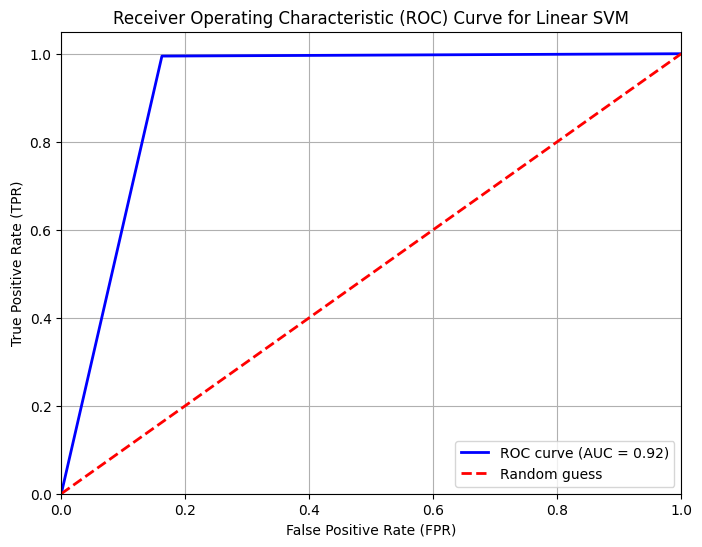

In [72]:
#ROC-AUC curve
linearSVM_fpr, linearSVM_tpr, linearSVM_thresholds = roc_curve(mcSVM_test_labels_bin, linearSVM_ypred_test_bin)

plt.figure(figsize=(8, 6))
plt.plot(linearSVM_fpr, linearSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % linearSVM_test_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [66]:
polySVM_ypred_train = polySVM.predict(mcSVM_train_images)
polySVM_ypred_test = polySVM.predict(mcSVM_test_images)

In [80]:
print("Poly Multiclass SVM Metrics for Training Data")
poly_cm_train = confusion_matrix(mcSVM_train_labels, polySVM_ypred_train)
print(poly_cm_train)
print(classification_report(mcSVM_train_labels, polySVM_ypred_train))

print("Poly Multiclass SVM Metrics for Test Data")
poly_cm_test = confusion_matrix(mcSVM_test_labels, polySVM_ypred_test)
print(poly_cm_test)
print(classification_report(mcSVM_test_labels, polySVM_ypred_test))

Poly Multiclass SVM Metrics for Training Data

[[2412    4    0    0]

 [  12 1669    0    0]

 [   0    0 1302    0]

 [   0    0    0  832]]

              precision    recall  f1-score   support



           0       1.00      1.00      1.00      2416

           1       1.00      0.99      1.00      1681

           2       1.00      1.00      1.00      1302

           3       1.00      1.00      1.00       832



    accuracy                           1.00      6231

   macro avg       1.00      1.00      1.00      6231

weighted avg       1.00      1.00      1.00      6231



Poly Multiclass SVM Metrics for Test Data

[[768  16   0   0]

 [ 26 533   0   0]

 [ 68 177   0   0]

 [  0   0   0  12]]

              precision    recall  f1-score   support



           0       0.89      0.98      0.93       784

           1       0.73      0.95      0.83       559

           2       0.00      0.00      0.00       245

           3       1.00      1.00      1.00        12



    acc

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, 

In [67]:
#Polynomial kernel training data
polySVM_train_var = np.mean(mcSVM_train_labels != polySVM_ypred_train)
print("Variance (LDA SVM training data):", polySVM_train_var)

#Polynomial kernel test data
polySVM_test_var = np.mean(mcSVM_test_labels != polySVM_ypred_test)
print("Variance (LDA SVM training data):", polySVM_test_var)

Variance (LDA SVM training data): 0.007061466859252127
Variance (LDA SVM training data): 0.161875


In [68]:
#Polynomial kernel training data
mcSVM_train_labels_bin = [1 if label == 1 else 0 for label in mcSVM_train_labels]
polySVM_ypred_train_bin = [1 if label == 1 else 0 for label in polySVM_ypred_train]

polySVM_train_auc = roc_auc_score(mcSVM_train_labels_bin, polySVM_ypred_train_bin)
print("LDA SVM AUC (Training Data):", polySVM_train_auc)

#Polynomial kernel test data
mcSVM_test_labels_bin = [1 if label == 1 else 0 for label in mcSVM_test_labels]
polySVM_ypred_test_bin = [1 if label == 1 else 0 for label in polySVM_ypred_test]

polySVM_test_auc = roc_auc_score(mcSVM_test_labels_bin, polySVM_ypred_test_bin)
print("LDA SVM AUC (Test Data):", polySVM_test_auc)

LDA SVM AUC (Training Data): 0.9901009341639918
LDA SVM AUC (Test Data): 0.9075481295506763


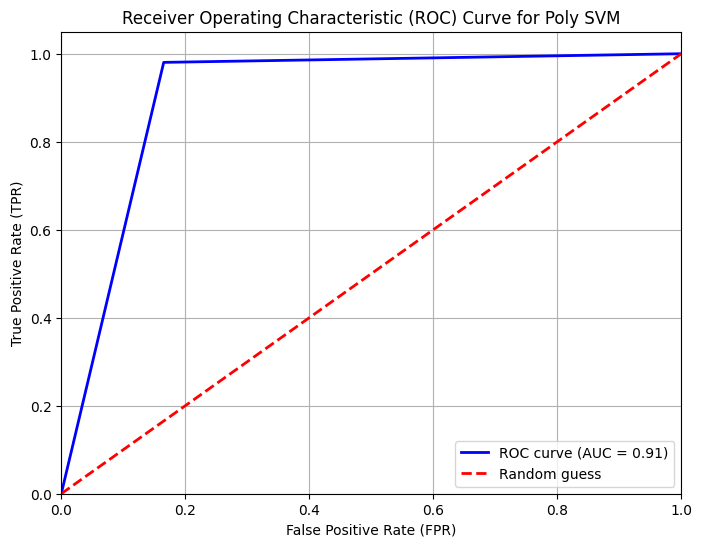

In [79]:
#ROC-AUC curve
polySVM_fpr, polySVM_tpr, polySVM_thresholds = roc_curve(mcSVM_test_labels_bin, polySVM_ypred_test_bin)

plt.figure(figsize=(8, 6))
plt.plot(polySVM_fpr, polySVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % polySVM_test_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Poly SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [70]:
rbfSVM_ypred_test = rbfSVM.predict(mcSVM_test_images)
rbfSVM_ypred_train = rbfSVM.predict(mcSVM_train_images)

In [82]:
print("RBF Multiclass SVM Metrics for Training Data")
rbf_cm_train = confusion_matrix(mcSVM_train_labels, rbfSVM_ypred_train)
print(rbf_cm_train)
print(classification_report(mcSVM_train_labels, rbfSVM_ypred_train))

print("RBF Multiclass SVM Metrics for Test Data")
rbf_cm_test = confusion_matrix(mcSVM_test_labels, rbfSVM_ypred_test)
print(rbf_cm_test)
print(classification_report(mcSVM_test_labels, rbfSVM_ypred_test))

RBF Multiclass SVM Metrics for Training Data

[[2348   68    0    0]

 [ 312 1369    0    0]

 [   1    0 1301    0]

 [   0    2    3  827]]

              precision    recall  f1-score   support



           0       0.88      0.97      0.92      2416

           1       0.95      0.81      0.88      1681

           2       1.00      1.00      1.00      1302

           3       1.00      0.99      1.00       832



    accuracy                           0.94      6231

   macro avg       0.96      0.94      0.95      6231

weighted avg       0.94      0.94      0.94      6231



RBF Multiclass SVM Metrics for Test Data

[[728  56   0   0]

 [156 403   0   0]

 [ 61 184   0   0]

 [  0   1   0  11]]

              precision    recall  f1-score   support



           0       0.77      0.93      0.84       784

           1       0.63      0.72      0.67       559

           2       0.00      0.00      0.00       245

           3       1.00      0.92      0.96        12



    accur

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, 

In [75]:
#RBF kernel training data
rbfSVM_train_var = np.mean(mcSVM_train_labels != rbfSVM_ypred_train)
print("Variance (RBF SVM training data):", rbfSVM_train_var)

#RBF kernel test data
rbfSVM_test_var = np.mean(mcSVM_test_labels != rbfSVM_ypred_test)
print("Variance (RBF SVM training data):", rbfSVM_test_var)

Variance (RBF SVM training data): 0.07238003530733429
Variance (RBF SVM training data): 0.24625


In [77]:
#RBF kernel training data
mcSVM_train_labels_bin = [1 if label == 1 else 0 for label in mcSVM_train_labels]
rbfSVM_ypred_train_bin = [1 if label == 1 else 0 for label in rbfSVM_ypred_train]

rbfSVM_train_auc = roc_auc_score(mcSVM_train_labels_bin, rbfSVM_ypred_train_bin)
print("RBF SVM AUC (Training Data):", rbfSVM_train_auc)

#RBF kernel test data
mcSVM_test_labels_bin = [1 if label == 1 else 0 for label in mcSVM_test_labels]
rbfSVM_ypred_test_bin = [1 if label == 1 else 0 for label in rbfSVM_ypred_test]

rbfSVM_test_auc = roc_auc_score(mcSVM_test_labels_bin, rbfSVM_ypred_test_bin)
print("RBF SVM AUC (Test Data):", rbfSVM_test_auc)

RBF SVM AUC (Training Data): 0.8862836093115689
RBF SVM AUC (Test Data): 0.7953615537557632


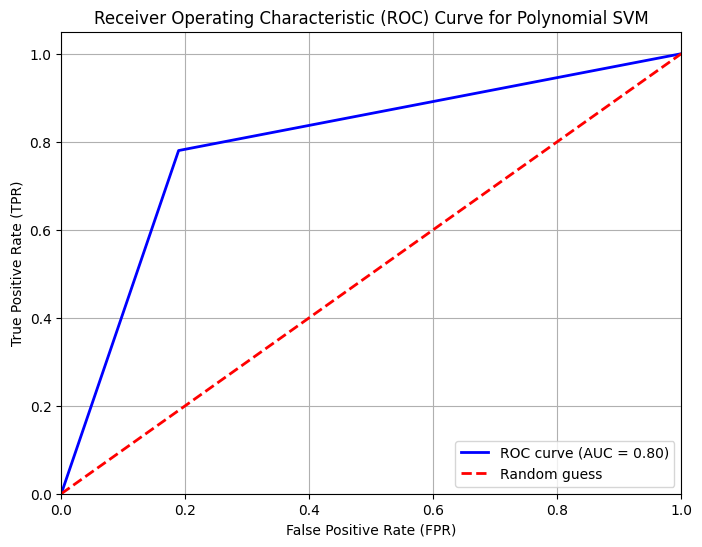

In [80]:
#ROC-AUC curve
rbfSVM_fpr, rbfSVM_tpr, rbfSVM_thresholds = roc_curve(mcSVM_test_labels_bin, rbfSVM_ypred_test_bin)

plt.figure(figsize=(8, 6))
plt.plot(rbfSVM_fpr, rbfSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % rbfSVM_test_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Polynomial SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [83]:
#LDA Linear
lda_linear_pred_train = logregLDA.predict(lda_baseX_train)
lda_linear_pred_test = logregLDA.predict(lda_baseX_test)

In [84]:
print("LDA Multiclass SVM Metrics for Training Data")
lda_linear_cm_train = confusion_matrix(mcSVM_train_labels, lda_linear_pred_train)
print(lda_linear_cm_train)
print(classification_report(mcSVM_train_labels, lda_linear_pred_train))

print('\n')
print("LDA Multiclass SVM Metrics for Test Data")
rbf_cm_test = confusion_matrix(mcSVM_test_labels, lda_linear_pred_test)
print(rbf_cm_test)
print(classification_report(mcSVM_test_labels, lda_linear_pred_test))

LDA Multiclass SVM Metrics for Training Data
[[2415    1    0    0]
 [   4 1677    0    0]
 [   0 1302    0    0]
 [   0  832    0    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2416
           1       0.44      1.00      0.61      1681
           2       0.00      0.00      0.00      1302
           3       0.00      0.00      0.00       832

    accuracy                           0.66      6231
   macro avg       0.36      0.50      0.40      6231
weighted avg       0.51      0.66      0.55      6231



LDA Multiclass SVM Metrics for Test Data
[[734  50   0   0]
 [ 62 497   0   0]
 [100 145   0   0]
 [  0  12   0   0]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       784
           1       0.71      0.89      0.79       559
           2       0.00      0.00      0.00       245
           3       0.00      0.00      0.00        12

    accuracy                       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [86]:
#Linear LDA kernel training data
linear_LDA_SVM_train_var = np.mean(mcSVM_train_labels != lda_linear_pred_train)
print("Variance (Linear LDA SVM training data):", linear_LDA_SVM_train_var)

#Linear LDA kernel test data
linear_LDA_SVM_test_var = np.mean(mcSVM_test_labels != lda_linear_pred_test)
print("Variance (Linear LDA SVM test data):", linear_LDA_SVM_test_var)

Variance (Linear LDA SVM training data): 0.34328358208955223
Variance (Linear LDA SVM test data): 0.230625


In [88]:
#Linear LDA kernel training data
mcSVM_train_labels_bin = [1 if label == 1 else 0 for label in mcSVM_train_labels]
lda_linear_pred_train_bin = [1 if label == 1 else 0 for label in lda_linear_pred_train]

linearLDA_SVM_train_auc = roc_auc_score(mcSVM_train_labels_bin, lda_linear_pred_train_bin)
print("Linear LDA SVM AUC (Training Data):", linearLDA_SVM_train_auc)

#Linear LDA kernel test data
mcSVM_test_labels_bin = [1 if label == 1 else 0 for label in mcSVM_test_labels]
lda_linear_pred_test_bin = [1 if label == 1 else 0 for label in lda_linear_pred_test]

linearLDA_SVM_test_auc = roc_auc_score(mcSVM_test_labels_bin, lda_linear_pred_test_bin)
print("Linear LDA SVM AUC (Test Data):", linearLDA_SVM_test_auc)

Linear LDA SVM AUC (Training Data): 0.7641948473893744
Linear LDA SVM AUC (Test Data): 0.8451201971408392


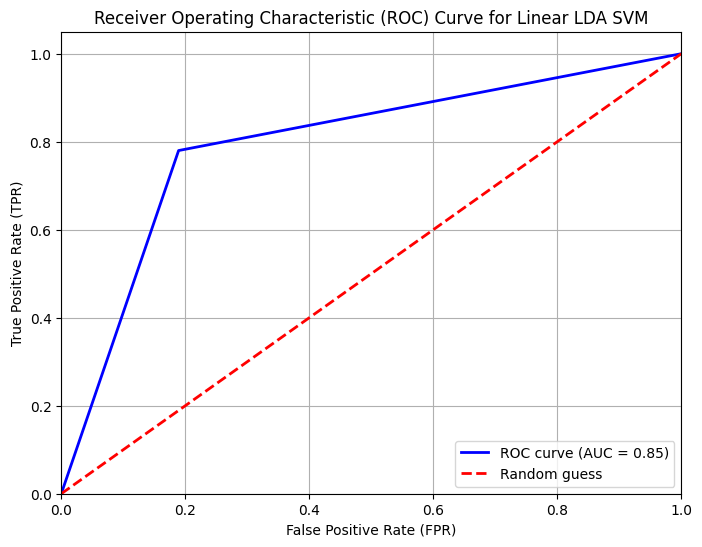

In [89]:
#ROC-AUC curve
linearLDA_SVM_fpr, linearLDA_SVM_tpr, linearLDA_SVM_thresholds = roc_curve(mcSVM_test_labels_bin, lda_linear_pred_test_bin)

plt.figure(figsize=(8, 6))
plt.plot(rbfSVM_fpr, rbfSVM_tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % linearLDA_SVM_test_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear LDA SVM')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### CNN Deep-Learning Model

##### CNN Model for Detection & Classification

The CNN architecture is explained in the report.

In [44]:
keras.backend.clear_session()

In [45]:
model = models.Sequential()
model.add(InputLayer(input_shape = (190,155,1), name = 'input_layer'))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())


model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D())

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))


model.add(layers.Dense(4, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [46]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 155, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 190, 155, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 77, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 95, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 95, 77, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 95, 77, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 38, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 47, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 23, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 19, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 9, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 9, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 9, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,879,348 (14.80 MB)

 Trainable params: 3,876,980 (14.79 MB)

 Non-trainable params: 2,368 (9.25 KB)

We will be using an exponential decay for our learning rate for hyperparameter tuning with an early stopping to prevent overfitting.

In [47]:
initial_learning_rate = 0.001     



lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.99,
    staircase=True
    )

opt = tf.keras.optimizers.Adam(learning_rate = lr_scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights= True, monitor = 'auc')
checkpoint = tf.keras.callbacks.ModelCheckpoint('alzheimer.keras', save_best_only=True, monitor='auc', mode='auto')

In [48]:
model.compile(optimizer= opt,
              loss = 'categorical_crossentropy',
              metrics= ['accuracy', 'precision', 'recall', keras.metrics.AUC(name = 'auc')])

In [49]:
cnn_X_train = baseImages3D
cnn_y_train = cnn_labels

insted of manually setting learing rate using an exponential decay function. we can use early stopping to prevent overfitting, etc

In [50]:
history = model.fit(cnn_X_train, cnn_y_train, epochs = 30, callbacks = [early_stop, checkpoint])

Epoch 1/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.5369 - auc: 0.7821 - loss: 1.1471 - precision: 0.5976 - recall: 0.4411
Epoch 2/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7823 - auc: 0.9575 - loss: 0.4662 - precision: 0.7997 - recall: 0.7622
Epoch 3/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8358 - auc: 0.9737 - loss: 0.3636 - precision: 0.8403 - recall: 0.8277
Epoch 4/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8916 - auc: 0.9862 - loss: 0.2673 - precision: 0.8957 - recall: 0.8860
Epoch 5/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8947 - auc: 0.9878 - loss: 0.2489 - precision: 0.8969 - recall: 0.8905
Epoch 6/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9286 - auc: 0.9927 - loss: 0.1902 - precision: 0.9306 - recall: 0.9272
Epoch 7/30
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9415 - auc: 0.9958 - loss: 0.1462 - precision: 0.9428 - recall: 0.9405
Epoch 8/30
195/195 ━━━━━━━━━━━━━━

##### CNN Model Results

In [51]:
#For training set
model_evaluate = model.evaluate(cnn_X_train, cnn_labels)

195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9903 - auc: 0.9998 - loss: 0.0255 - precision: 0.9903 - recall: 0.9903


In [52]:
#For Testing Set
cnn_prediction = model.predict(cnn_image_test)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [53]:
model.evaluate(cnn_image_test, cnn_test_labels)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8022 - auc: 0.8894 - loss: 1.6211 - precision: 0.8025 - recall: 0.8022


[1.5501739978790283,
 0.8143749833106995,
 0.8148843050003052,
 0.8143749833106995,
 0.896246075630188]

##### Visualizing Regions of Interest of CNN

In [17]:
from tensorflow.keras.preprocessing import image

In [59]:
def preprocessing_image(img):
    preprocessed_img = image.img_to_array(img)
    preprocessed_img = np.expand_dims(preprocessed_img, axis = 0)
    preprocessed_img = preprocessed_img / 255 #normalize
    return preprocessed_img

We will do some visualization of the the CNN filters to visualize what CNN does on the image for the first CNN layer and the fourth CNN layer.

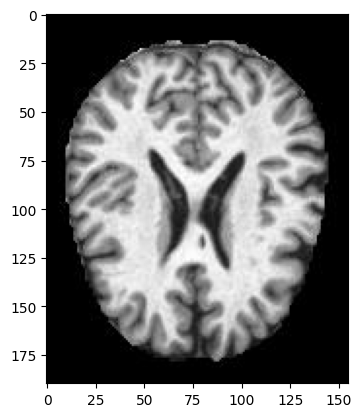

In [60]:
img_test = X_train_augmented[1]
img_tensor = preprocessing_image(img_test)
plt.imshow(img_tensor[0], cmap = 'gray') 
plt.show()

In [61]:
layer_outputs = [layer.output for layer in model.layers[:20]] 

activation_model = models.Model(inputs = model.inputs, outputs = layer_outputs)

activations = activation_model.predict(img_tensor) 

first_layer_activation = activations[0] 
fourth_layer_activation = activations[6]

2024-04-25 16:38:29.925889: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58900: 1.87366, expected 1.34248
2024-04-25 16:38:29.925946: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58901: 2.52815, expected 1.99697
2024-04-25 16:38:29.925956: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58902: 2.36369, expected 1.83251
2024-04-25 16:38:29.925964: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58903: 2.32438, expected 1.7932
2024-04-25 16:38:29.925977: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58904: 2.29503, expected 1.76385
2024-04-25 16:38:29.925985: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58905: 2.0017, expected 1.47052
2024-04-25 16:38:29.925992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 58906: 1.99274, expected 1.46156
2024-04-25 16:38:29.926000: E

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


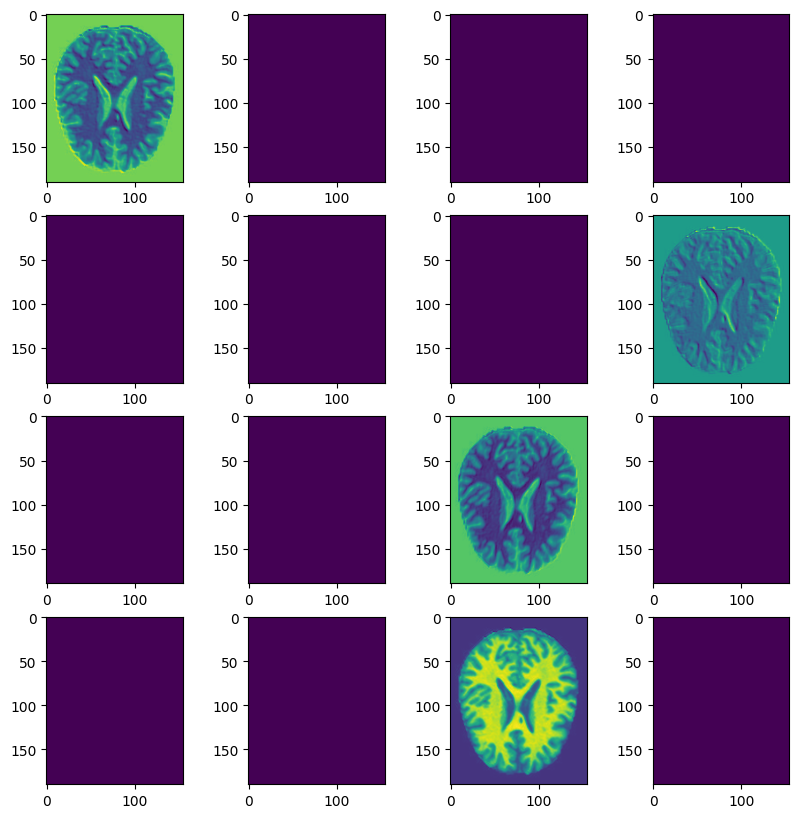

In [62]:
idx = 1
fig,axes = plt.subplots(4,4, figsize = (10,10))
for i in range(4):
    for z in range(4):
        axes[i,z].imshow(first_layer_activation[0,:,:,idx-1], cmap = 'viridis')
        idx+=1

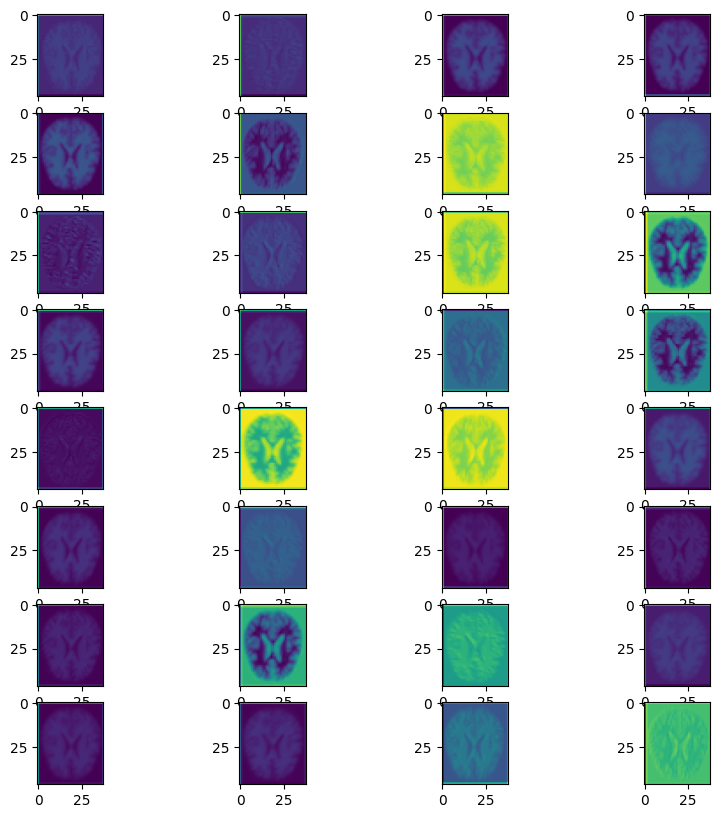

In [63]:
idx = 1
fig,axes = plt.subplots(8,4, figsize = (10,10))
for i in range(8):
    for z in range(4):
        axes[i,z].imshow(fourth_layer_activation[0,:,:,idx-1], cmap = 'viridis')
        idx+=1

We will visualize what the CNN see's for each category using a Saliency Map to identify the regions that contribute the most for classification.

In [80]:
from tf_keras_vis.utils.scores import CategoricalScore
score_NonDemented = CategoricalScore([0])
score_VeryMildDemented =CategoricalScore([1])
score_MildDemented = CategoricalScore([2])
score_ModerateDemented = CategoricalScore([3])

In [81]:
NonDemented_image = preprocessing_image(NonDemented_train[1])
VeryMildDemented_image = preprocessing_image(VeryMildDemented_train[1])
MildDemented_image = preprocessing_image(MildDemented_train[1])
ModerateDemented_image = preprocessing_image(ModerateDemented_train[1])
images = np.asarray([NonDemented_image, VeryMildDemented_image, MildDemented_image, ModerateDemented_image])

In [82]:
from tf_keras_vis.saliency import Saliency
# Create Saliency object.
saliency = Saliency(model,
                    clone=True)

In [83]:
saliency_map_NonDemented = saliency(score_NonDemented, NonDemented_image[0], smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.10)
saliency_map_VeryMildDemented = saliency(score_VeryMildDemented, VeryMildDemented_image[0], smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.10)
saliency_map_MildDemented = saliency(score_MildDemented, MildDemented_image[0], smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.10)
saliency_map_ModerateDemented = saliency(score_ModerateDemented, ModerateDemented_image[0], smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.10)


This is what the model uses for prediction without an overlay on the original image. Lighter regions contribute more.

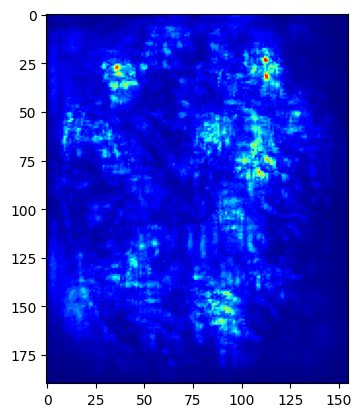

In [84]:
plt.imshow(saliency_map_MildDemented[0], cmap = 'jet')
plt.show()

This is how the Saliency Map looks as an overlay of the original images.

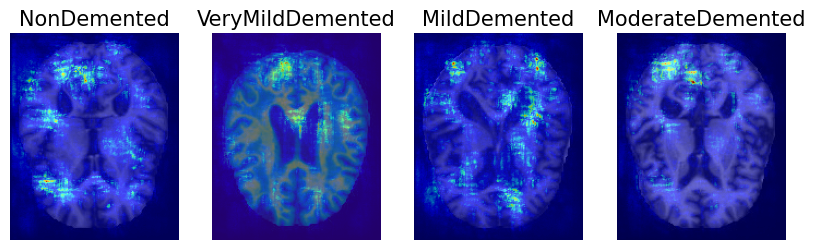

In [85]:
fig,axes = plt.subplots(1,4, figsize =(10,10))
axes[0].imshow(NonDemented_image[0], cmap = 'gray')
axes[0].imshow(saliency_map_NonDemented[0], cmap = 'jet', alpha = 0.7)
axes[0].axis('off')

axes[1].imshow(VeryMildDemented_image[0])
axes[1].imshow(saliency_map_VeryMildDemented[0], cmap = 'jet', alpha = 0.5)
axes[1].axis('off')

axes[2].imshow(MildDemented_image[0], cmap = 'gray')
axes[2].imshow(saliency_map_MildDemented[0], cmap = 'jet', alpha = 0.7)
axes[2].axis('off')

axes[3].imshow(ModerateDemented_image[0], cmap = 'gray')
axes[3].imshow(saliency_map_ModerateDemented[0], cmap = 'jet', alpha = 0.6)
axes[3].axis('off')

axes[0].set_title('NonDemented', fontsize = 15)
axes[1].set_title('VeryMildDemented', fontsize = 15)
axes[2].set_title('MildDemented', fontsize = 15)
axes[3].set_title('ModerateDemented', fontsize = 15)


plt.show()